In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
!git clone https://github.com/FilLTP89/HEMEW3D.git

In [ ]:
%cd /content/drive/MyDrive/HEMEW3D

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

from simulation.utils import plot3Dcube

A_MIN = 1071 # minimum material value (shear wave velocity in m/s)
A_MAX = 4500 # maximum material value (shear wave velocity in m/s)

This notebook shows how to plot materials and velocity fields downloaded from the database. 

# Materials

Read 2000 materials downloaded from the data repository. 

In [2]:
a = np.load('./data/materials0-9.npy')
print(a.shape)

(10, 32, 32, 32)


Plot a 3D element

/home/kltpk89/Data/Filippo/HEMEW3D/simulation/utils.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


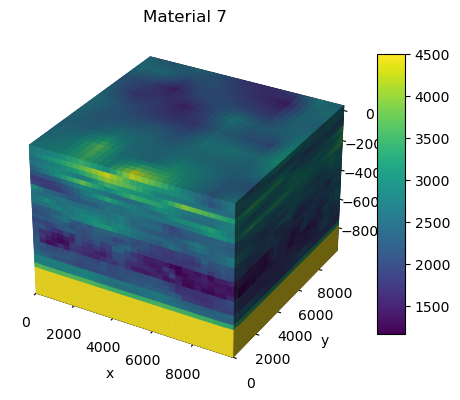

In [3]:
element = 7

plot3Dcube(a[element], Xvec = np.linspace(0, 9600, 32), Yvec = np.linspace(0, 9600, 32), 
           Zvec = np.linspace(-9600, 0, 32), 
           figsize=(5.5,4), title=f'Material {element}')

Plot slices of the material in the three directions. 

In [ ]:
ticks = np.linspace(-0.5, 31.5, 4) # rename intrinsic ticks between 0 and 32 to real meter values
ticklabels = np.linspace(0, 9600, 4).astype(int)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
# West-East view at y=0m
im = ax1.imshow(a[element, :, 0, :].T, vmin=A_MIN, vmax=A_MAX, origin='lower')
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticklabels)
ax1.set_xlabel('x (m)')
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticklabels-9600)
ax1.set_ylabel('z (m)')
ax1.set_title('West-East view at y=0m')

# South-North view at x=9600m
ax2.imshow(a[element, -1, :, :].T, vmin=A_MIN, vmax=A_MAX, origin='lower')
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticklabels)
ax2.set_xlabel('y (m)')
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticklabels-9600)
ax2.set_ylabel('z (m)')
ax2.set_title('South-North view at x=9600m')

# upward view
ax3.imshow(a[element, :, :, -1].T, vmin=A_MIN, vmax=A_MAX, origin='lower')
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticklabels)
ax3.set_xlabel('x (m)')
ax3.set_yticks(ticks)
ax3.set_yticklabels(ticklabels)
ax3.set_ylabel('y (m)')
ax3.set_title('Upward view')

fig.subplots_adjust(wspace=0.4, left=0.07, right=0.9)
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cax)
plt.show()

# Velocity fields

Read a batch of 100 velocity fields

In [ ]:
v = pd.concat([pd.read_feather(f'./data/velocity{i}.feather', columns=list(range(1,2006))) for i in range(10)])
v.columns = list(v.columns[:5]) + list(v.columns[5:].astype(float))
v.head()

List the sensors' coordinates

In [ ]:
print(np.unique(v.x))
print(np.unique(v.y))

Print the timeseries at a given sensor located at `(sensor_x, sensor_y)`. 

In [ ]:
sensor_x, sensor_y = 2630, 4490 # sensor coordinates
v_element = v.loc[(v.run==element)&(v.x==sensor_x)&(v.y==sensor_y)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6,5))
fig.subplots_adjust(left=0.15, right=0.95, top=0.9)
ax1.plot(v_element.loc[v_element.field=='Veloc E'].iloc[:,5:].T, 'k')
ax1.set_ylabel('$V_E$ (m/s)')

ax2.plot(v_element.loc[v_element.field=='Veloc N'].iloc[:,5:].T, 'k')
ax2.set_ylabel('$V_N$ (m/s)')

ax3.plot(v_element.loc[v_element.field=='Veloc Z'].iloc[:,5:].T, 'k')
ax3.set_ylabel('$V_Z$ (m/s)')
ax3.set_xlim([0, 20])
ax3.set_xlabel('Time (s)')
fig.suptitle(f'Velocity field at ({int(sensor_x)}m; {int(sensor_y)}m) for element {element}')

plt.show()

Reshape `.feather` data into a numpy array. For each component, the dimensions are (sample index, y index, x index, timestep)

In [27]:
vE = v.loc[(v.field=='Veloc E')].sort_values(by=['run','y','x']).iloc[:,5:].values.reshape(10,16,16,2000)
vN = v.loc[(v.field=='Veloc N')].sort_values(by=['run','y','x']).iloc[:,5:].values.reshape(10,16,16,2000)
vZ = v.loc[(v.field=='Veloc Z')].sort_values(by=['run','y','x']).iloc[:,5:].values.reshape(10,16,16,2000)

Sanity check that the formatting is correct.

In [ ]:
isensor_x = np.random.randint(16)
isensor_y = np.random.randint(16)
sensor_x = np.unique(v.x)[isensor_x]
sensor_y = np.unique(v.y)[isensor_y]
v_element = v.loc[(v.run==element)&(v.x==sensor_x)&(v.y==sensor_y)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6))
ax1.plot(v_element.loc[v_element.field=='Veloc E'].iloc[:,5:].T, 'y', linewidth=3)
ax1.plot(np.linspace(0, 19.99, 2000), vE[element, isensor_y, isensor_x, :], 'k', linewidth=1)
ax1.set_ylabel('$V_E$ (m/s)')

ax2.plot(v_element.loc[v_element.field=='Veloc N'].iloc[:,5:].T, 'y', linewidth=3)
ax2.plot(np.linspace(0, 19.99, 2000), vN[element, isensor_y, isensor_x, :], 'k', linewidth=1)
ax2.set_ylabel('$V_N$ (m/s)')

ax3.plot(v_element.loc[v_element.field=='Veloc Z'].iloc[:,5:].T, 'y', linewidth=3)
ax3.plot(np.linspace(0, 19.99, 2000), vZ[element, isensor_y, isensor_x, :], 'k', linewidth=1)
ax3.set_ylabel('$V_Z$ (m/s)')
ax3.set_xlim([0, 20])
ax3.set_xlabel('Time (s)')
fig.suptitle(f'Velocity field at ({int(sensor_x)}m; {int(sensor_y)}m) for element {element}')

plt.show()

Snapshot at a given time `t`. 

In [ ]:
t = 4
m = np.max(np.abs(vE[element, :, :, int(t*100)]))

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(vE[element, :, :, int(t*100)], vmin = -m, vmax=m, cmap='RdBu', origin='lower', interpolation='none')
fig.colorbar(im, ax=ax, label = '$V_E$ (m/s)', shrink=0.7)

ticks = np.linspace(-0.5, 15.5, 6)
ax.set_xticks(ticks)
ax.set_xticklabels((600*(ticks+0.5)).astype(int))
ax.set_xlabel('x (m)')

ax.set_yticks(ticks)
ax.set_yticklabels((600*(ticks+0.5)).astype(int))
ax.set_ylabel('y (m)')

ax.set_title(f'Velocity field E-W at t={t:.2f}s for element {element}')

fig.tight_layout()
plt.show()